In [1]:
from typing import Union
import pandas as pd
import numpy as np
import pymc as pm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
sns.set_theme()

pm.__version__

'4.2.0'

### Data Retrieval and Formatting

House (individual) measurements of radon activity, Radon Measure at the county (group) level, Consider only Minnesota, then average the uranium measurements in a county and give each individual measurement that county uranium level

In [2]:
def generate_data():
    rename_dict = {}
    data = pd.read_csv("datasets/ARM_DATA/radon/srrs2.dat")
    uranium = pd.read_csv("datasets/ARM_DATA/radon/cty.dat")

    for col in data.columns:
        rename_dict[col] = col.strip()
    data = data.rename(rename_dict, axis=1)
    data["county"] = data["county"].str.strip()

    for col in data.columns:
        rename_dict[col] = col.strip()
    uranium = uranium.rename(rename_dict, axis=1)
    uranium["county"] = uranium["cty"].str.strip()
    uranium = uranium.rename({"ctfips":"cntyfips"}, axis=1)

    data = data[data["state"] == "MN"]
    uranium = uranium[uranium["st"] == "MN"]

    data = data[["cntyfips", "county", "activity", "floor"]]
    uranium = uranium[["cntyfips", "county", "Uppm"]]

    uranium = uranium.groupby(["cntyfips", "county"]).mean()["Uppm"].reset_index()
    # uranium = uranium[uranium["ctfips"].isin(data["ctfips"])]
    # data = data.merge(uranium[["ctfips","Uppm"]], how="inner", left_on="cntyfips", right_on="ctfips")
    uranium = uranium[uranium["cntyfips"].isin(data["cntyfips"].unique())]

    return data, uranium

data, data_u = generate_data()

In [3]:
le = LabelEncoder()
data["county_id"] = le.fit_transform(data["cntyfips"])
data_u["county_id"] = le.transform(data_u["cntyfips"])
counties = data["county_id"].unique()
county_id_map = np.array([data_u[data_u["county_id"] == i]["county"].to_string(index=False) for i in data["county_id"].unique()])

In [4]:
county_counts = data[["county_id","activity"]].groupby("county_id").count().reset_index()

In [5]:
county_counts_sort = np.argsort(county_counts["activity"].to_numpy())

In [6]:
data_f = data[["county_id","floor"]].groupby("county_id").mean().reset_index()

Data transformations

In [7]:
def log1p(x:Union[np.ndarray, pd.Series]) -> Union[np.ndarray, pd.Series]:
    return np.log(x + 0.01)

def exp1m(x:Union[np.ndarray, pd.Series]) -> Union[np.ndarray, pd.Series]:
    return np.exp(x) - 0.01

def scale(x:Union[np.ndarray, pd.Series]) -> Union[np.ndarray, pd.Series]:
    z = (x - x.mean()) / x.std()
    return z

Get counties, and do generic transformations

In [8]:
y = log1p(data["activity"].to_numpy())
u = scale(data_u["Uppm"].to_numpy())
f = data["floor"].to_numpy()
c = data["county_id"].to_numpy()
f_bar = data_f["floor"].to_numpy()

### m0: Complete Pooling
    Collapse all county level information, sigma_a goes to 0
    y = alpha + beta * floor

In [9]:
coords = {
    "obs_id": np.arange(len(y))
    }
with pm.Model(coords=coords) as m0:
    activity = pm.ConstantData("activity", y, dims="obs_id")
    floor = pm.MutableData("floor", f, dims="obs_id")
    
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 10)
    tau_y = pm.Gamma("tau_y", 4, 4)

    resp = alpha + beta * floor

    obs = pm.Normal("obs", mu=resp, sigma=1/tau_y, observed=activity, dims="obs_id")

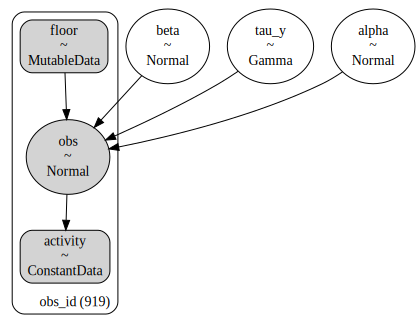

In [10]:
pm.model_to_graphviz(m0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


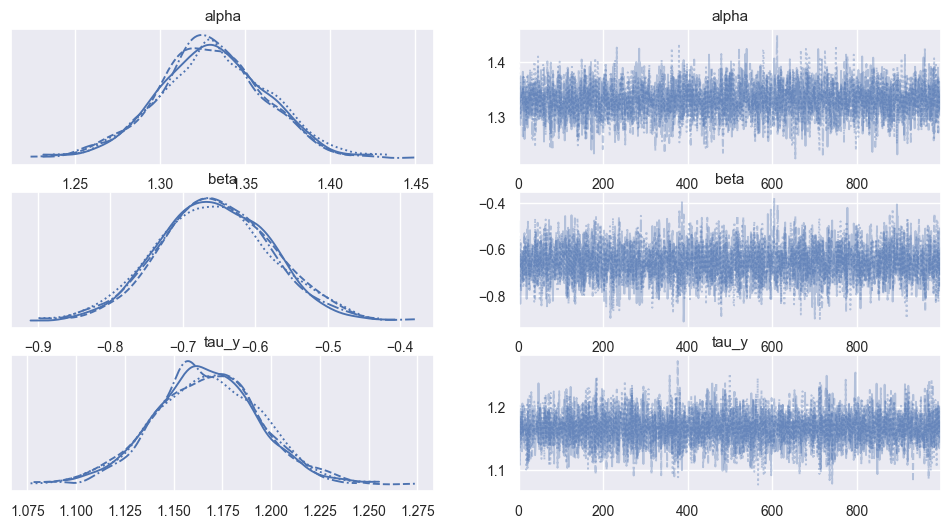

In [11]:
with m0:
    trace_m0 = pm.sample()
    posterior_m0 = pm.sample_posterior_predictive(trace_m0)
    pm.plot_trace(trace_m0)
    

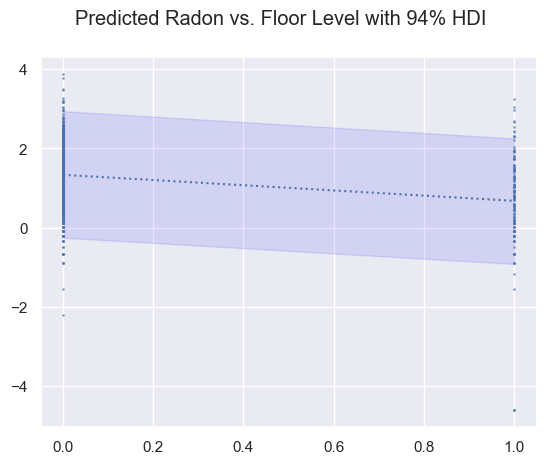

In [12]:
posterior_vars_m0_mean = trace_m0.posterior[["alpha","beta","tau_y"]].mean(dim=["chain","draw"])
posterior_vars_m0_sd = trace_m0.posterior[["alpha","beta"]].std(dim=["chain","draw"])

def plot():
    a = posterior_vars_m0_mean.get("alpha").to_numpy()
    b = posterior_vars_m0_mean.get("beta").to_numpy()
    b_sd = posterior_vars_m0_sd.get("beta").to_numpy()
    t = posterior_vars_m0_mean.get("tau_y").to_numpy()
    
    x = np.linspace(0,1,100)
    # line_upper = a + b * x + 1.96 * t
    line = a + b * x 
    # line_lower = a + b * x - 1.96 * t

    pm.plot_hdi(x=f, y=posterior_m0.posterior_predictive.to_array().squeeze(), color="blue", fill_kwargs={"alpha":0.1})
    plt.scatter(x=f, y=y, s=1, alpha=0.5)
    plt.plot(x, line, linestyle=":")
    plt.suptitle("Predicted Radon vs. Floor Level with 94% HDI")

plot()

### m1: No Pooling
    Every county gets its own independent predictor,  Effectively, sigma_alpha -> infinity
    y = county + floor * x

In [13]:
coords = {
    "obs_id": np.arange(len(y)),
    "county_id": np.arange(len(le.classes_))
}
with pm.Model(coords=coords) as m1:
    floor = pm.MutableData("floor", f, dims="obs_id")
    county = pm.MutableData("county", c, dims="obs_id")

    alpha = pm.Normal("alpha", mu=0, sigma=10, dims="county_id")
    beta = pm.Normal("beta", mu=0, sigma=10)

    resp = alpha[county] + beta * floor

    tau_y = pm.Gamma("tau_y", 4, 4)

    obs = pm.Normal("obs", mu = resp, sigma = 1/tau_y, observed=y, dims="obs_id")
    
    pm.model_to_graphviz(m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


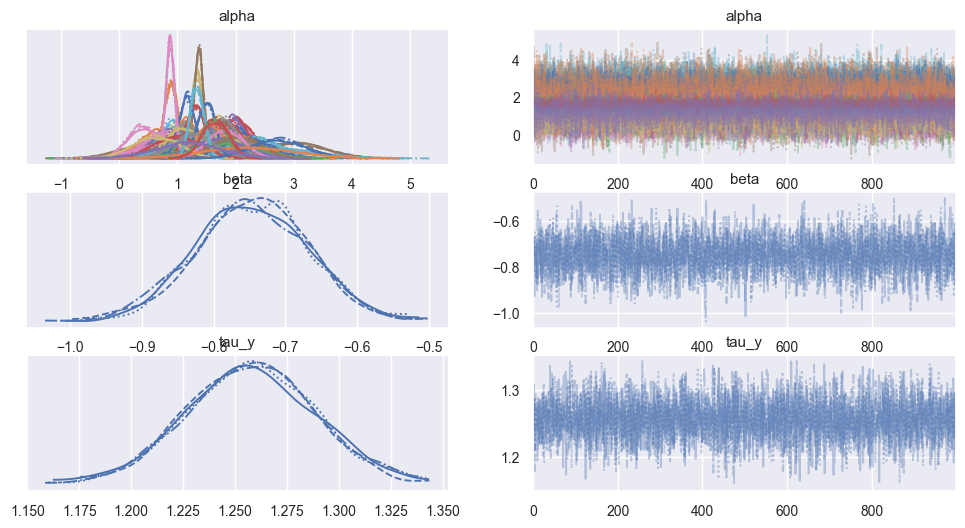

In [14]:
with m1:
    trace_m1 = pm.sample()
    posterior_m1 = pm.sample_posterior_predictive(trace_m1)
    pm.plot_trace(trace_m1)

Text(0.5, 0.98, 'Predicted Radon vs. Floor Level with 94% HDI')

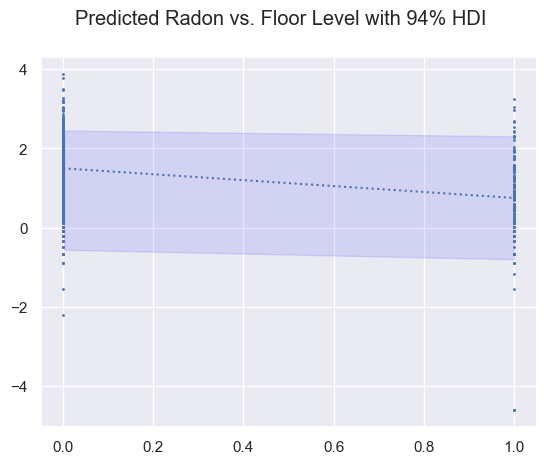

In [15]:
a = trace_m1["posterior"].stack(sample=["chain","draw"])["alpha"].mean().to_numpy()
b = trace_m1["posterior"].stack(sample=["chain","draw"])["beta"].mean().to_numpy()

x = np.linspace(0,1,100)
line = a + b * x 

pm.plot_hdi(x=f, y=posterior_m1["posterior_predictive"].to_array().squeeze(), color="blue", fill_kwargs={"alpha":0.1})
plt.scatter(x=f, y=y, s=1)
plt.plot(x, line, linestyle=":")
plt.suptitle("Predicted Radon vs. Floor Level with 94% HDI")

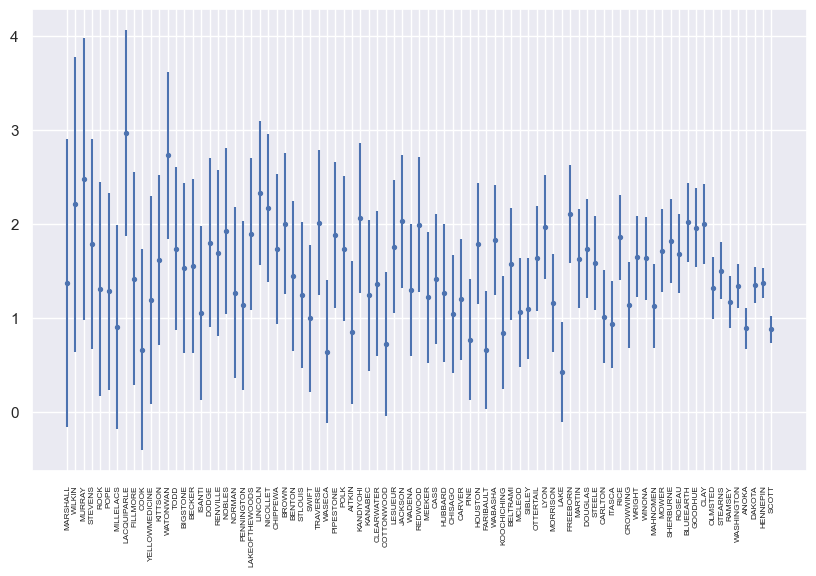

In [16]:
def plot_alphas(trace, sorts=None):
    post_mean = trace.posterior[["alpha","tau_y"]].mean(dim=["chain","draw"])
    post_sd = trace.posterior[["alpha","tau_y"]].std(dim=["chain","draw"])

    alpha_u = post_mean.get("alpha").to_numpy() + 1.96*post_sd.get("alpha").to_numpy()
    alpha_l = post_mean.get("alpha").to_numpy() - 1.96*post_sd.get("alpha").to_numpy()
    alpha = post_mean.get("alpha").to_numpy()

    if sorts is not None:
        sorted = sorts
    else:
        sorted = np.argsort(alpha)

    fig, ax = plt.subplots()
    plt.xticks(rotation=90, size=6)
    fig.set_size_inches((10,6))
    ax.scatter(x=county_id_map[sorted], y=alpha[sorted], s = 8)
    ax.vlines(x=county_id_map[sorted], ymin=alpha_l[sorted], ymax=alpha_u[sorted])
    # return post_mean, post_sd

plot_alphas(trace_m1, sorts=county_counts_sort)

### m2: Pooled Model - Pooled Intercept Only varying by county

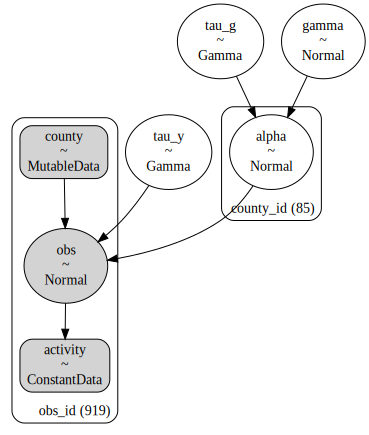

In [17]:
coords = {
    "obs_id": np.arange(len(y)),
    "county_id": np.arange(len(le.classes_))
}
with pm.Model(coords=coords) as m2:
    county = pm.MutableData("county", c, dims="obs_id")
    activity = pm.ConstantData("activity", y, dims="obs_id")
    
    gamma = pm.Normal("gamma", mu=0, sigma=10)
    tau_g = pm.Gamma("tau_g", mu=4, sigma=4)
    
    alpha = pm.Normal("alpha", mu=gamma, sigma=1/tau_g, dims="county_id")
    
    resp = alpha[county]

    tau_y = pm.Gamma("tau_y", 4,4)

    obs = pm.Normal("obs", mu=resp, sigma=1/tau_y, observed=activity, dims="obs_id")

pm.model_to_graphviz(m2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, tau_g, alpha, tau_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


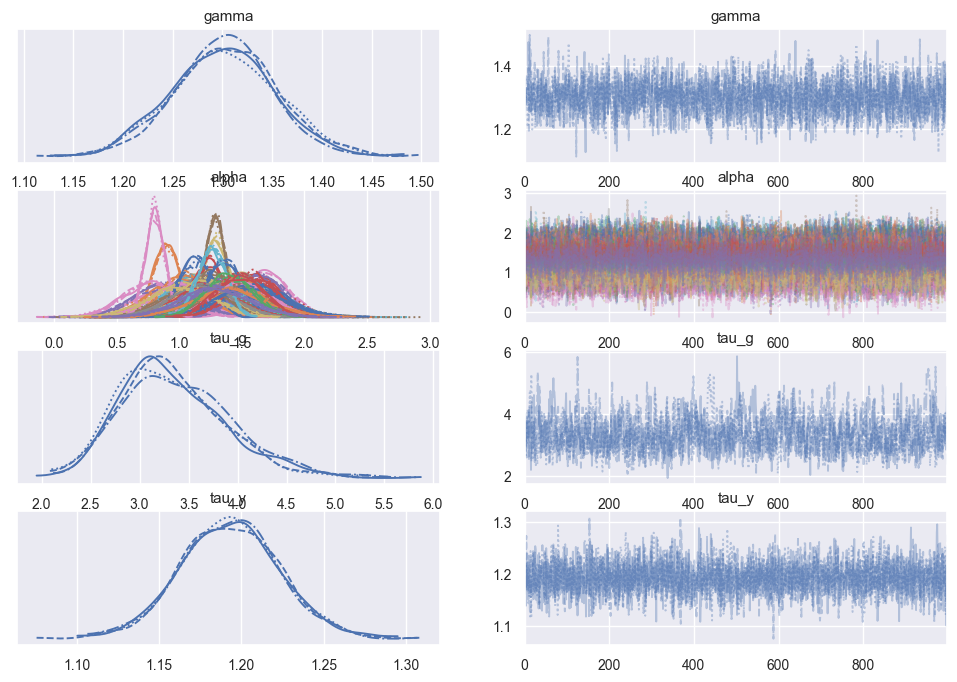

In [18]:
with m2:
    trace_m2 = pm.sample()
    pm.plot_trace(trace_m2)
    posterior_m2 = pm.sample_posterior_predictive(trace_m2)

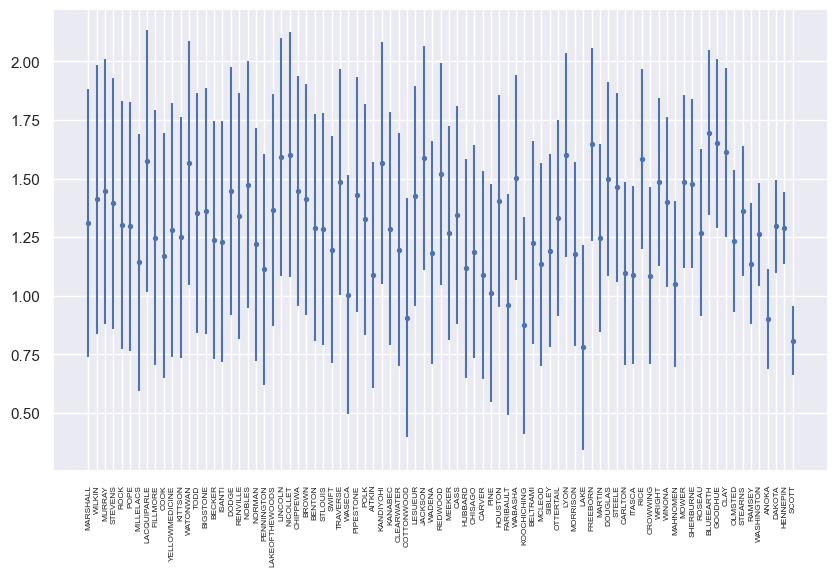

In [19]:
plot_alphas(trace_m2, sorts=county_counts_sort)

### m3: Pooled intercept with a floor predictor

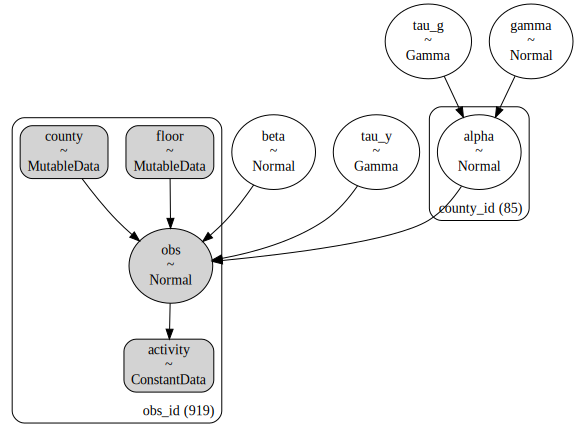

In [20]:
coords = {
    "obs_id": np.arange(len(y)),
    "county_id": np.arange(len(le.classes_))
}
with pm.Model(coords=coords) as m3:
    county = pm.MutableData("county", c, dims="obs_id")
    activity = pm.ConstantData("activity", y, dims="obs_id")
    floor = pm.MutableData("floor", f, dims="obs_id")

    gamma = pm.Normal("gamma", mu=0, sigma=10)
    tau_g = pm.Gamma("tau_g", mu=4, sigma=4)
    
    alpha = pm.Normal("alpha", mu=gamma, sigma=1/tau_g, dims="county_id")
    beta = pm.Normal("beta", mu=0, sigma=10)

    resp = alpha[county] + beta * floor

    tau_y = pm.Gamma("tau_y", 4, 4)

    obs = pm.Normal("obs", mu=resp, sigma=1/tau_y, observed=activity, dims="obs_id")
    
pm.model_to_graphviz(m3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, tau_g, alpha, beta, tau_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


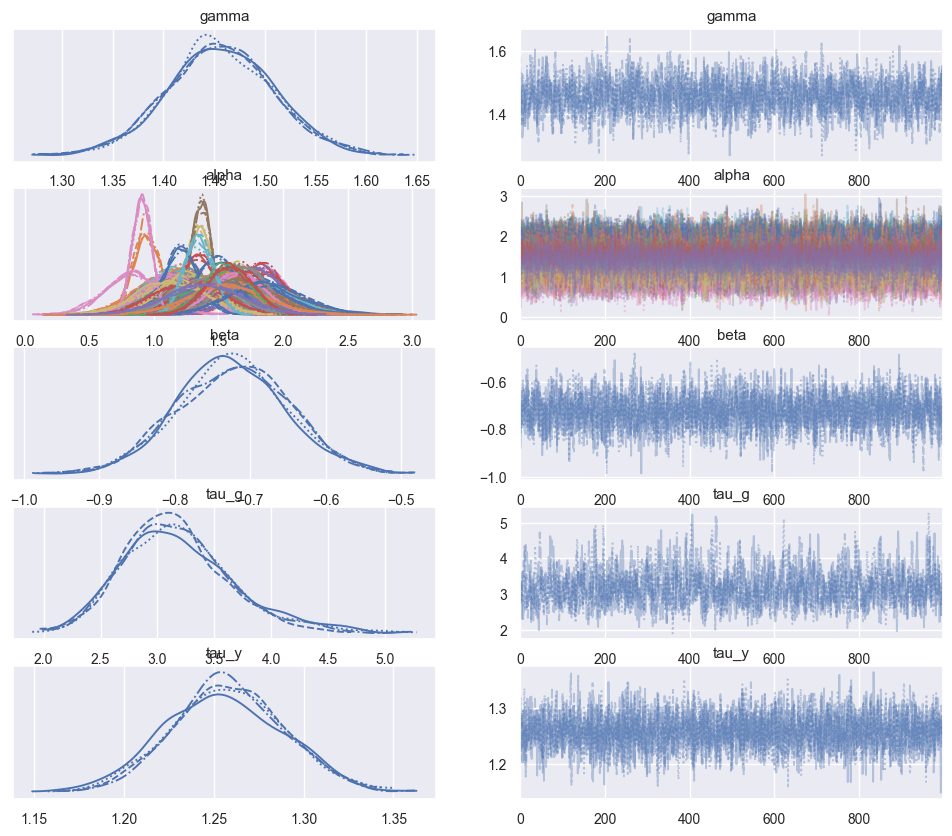

In [21]:
with m3:
    trace_m3 = pm.sample()
    posterior_m3 = pm.sample_posterior_predictive(trace_m3)
    pm.plot_trace(trace_m3)

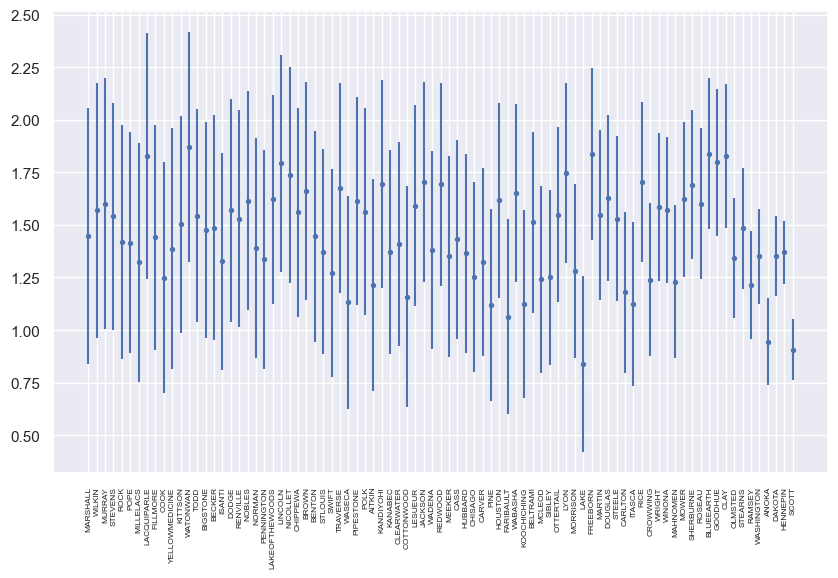

In [22]:
plot_alphas(trace_m3, sorts=county_counts_sort)

### m4: Uranium Predictor at County Level

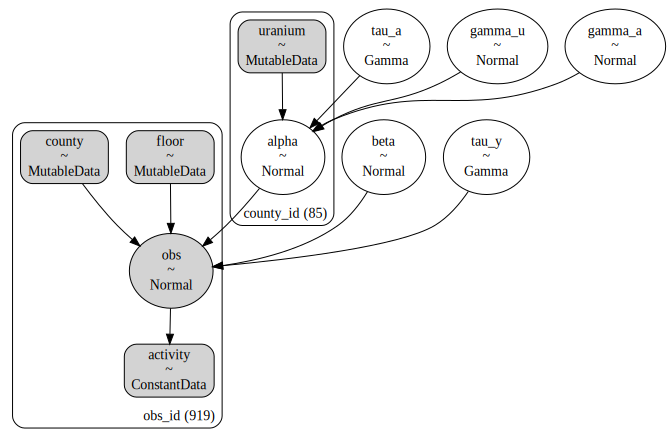

In [23]:
coords = {
    "obs_id": np.arange(len(y)),
    "county_id": np.arange(len(le.classes_))
}
with pm.Model(coords=coords) as m4:
    activity = pm.ConstantData("activity", y, dims="obs_id")
    floor = pm.MutableData("floor", f, dims="obs_id")
    county = pm.MutableData("county", c, dims="obs_id")
    uranium = pm.MutableData("uranium", u, dims="county_id")

    gamma_a = pm.Normal("gamma_a", mu=0, sigma=10)
    gamma_u = pm.Normal("gamma_u", mu=0, sigma=10)
    tau_a = pm.Gamma("tau_a", mu=4, sigma=4)

    a = gamma_a + gamma_u*uranium

    alpha = pm.Normal("alpha", mu=a, sigma=1/tau_a, dims="county_id")
    beta = pm.Normal("beta", mu=0, sigma=10)

    resp = alpha[county] + beta * floor

    tau_y = pm.Gamma("tau_y", 4,4)

    obs = pm.Normal("obs", mu=resp, sigma=1/tau_y, observed=activity, dims="obs_id")
    
pm.model_to_graphviz(m4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma_a, gamma_u, tau_a, alpha, beta, tau_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


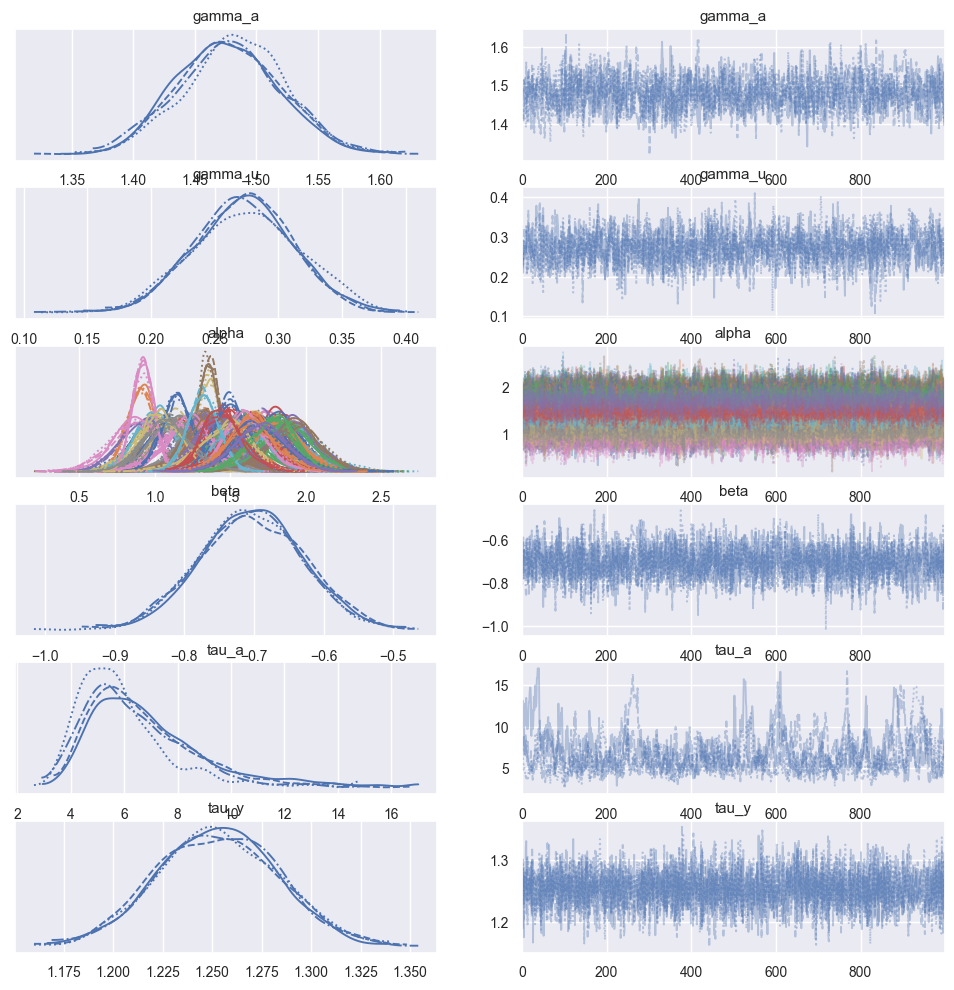

In [24]:
with m4:
    trace_m4 = pm.sample()
    posterior_m4 = pm.sample_posterior_predictive(trace_m4)
    pm.plot_trace(trace_m4)

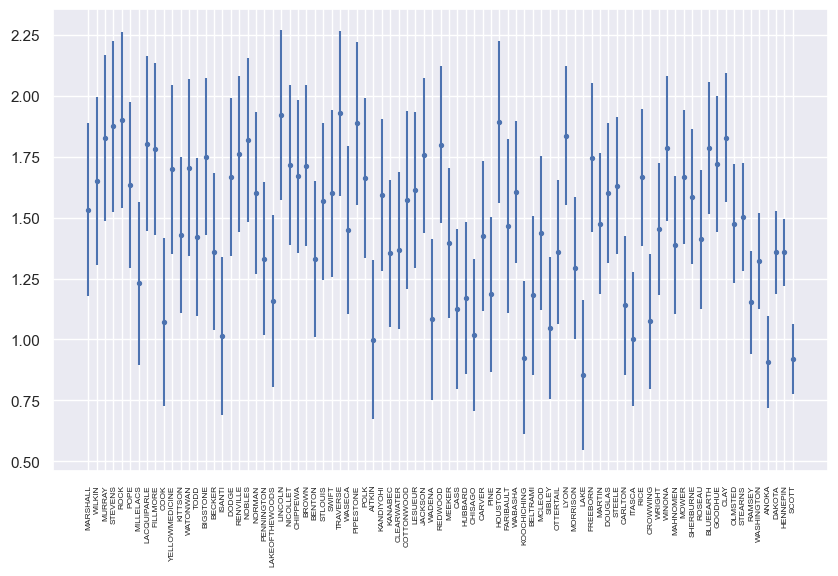

In [25]:
plot_alphas(trace_m4, county_counts_sort)

### m5: Uranium Predictor at County Level w/ Floor Measurement "Bias"

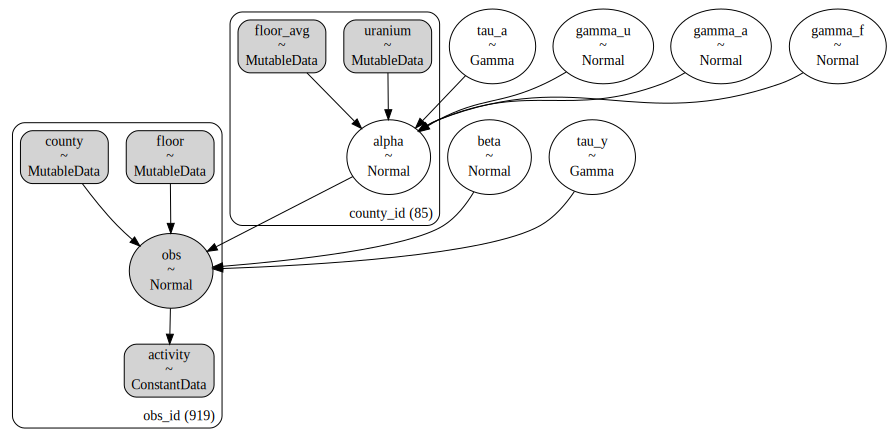

In [26]:
coords = {
    "obs_id": np.arange(len(y)),
    "county_id": np.arange(len(le.classes_))
}
with pm.Model(coords=coords) as m5:
    activity = pm.ConstantData("activity", y, dims="obs_id")
    floor = pm.MutableData("floor", f, dims="obs_id")
    county = pm.MutableData("county", c, dims="obs_id")
    uranium = pm.MutableData("uranium", u, dims="county_id")
    floor_avg  =pm.MutableData("floor_avg", f_bar, dims="county_id")

    gamma_a = pm.Normal("gamma_a", mu=0, sigma=10)
    gamma_u = pm.Normal("gamma_u", mu=0, sigma=10)
    gamma_f = pm.Normal("gamma_f", mu=0, sigma=10)
    tau_a = pm.Gamma("tau_a", mu=4, sigma=4)

    a = gamma_a + gamma_u*uranium + gamma_f*floor_avg

    alpha = pm.Normal("alpha", mu=a, sigma=1/tau_a, dims="county_id")
    beta = pm.Normal("beta", mu=0, sigma=10)

    resp = alpha[county] + beta * floor

    tau_y = pm.Gamma("tau_y", 4,4)

    obs = pm.Normal("obs", mu=resp, sigma=1/tau_y, observed=activity, dims="obs_id")

pm.model_to_graphviz(m5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma_a, gamma_u, gamma_f, tau_a, alpha, beta, tau_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


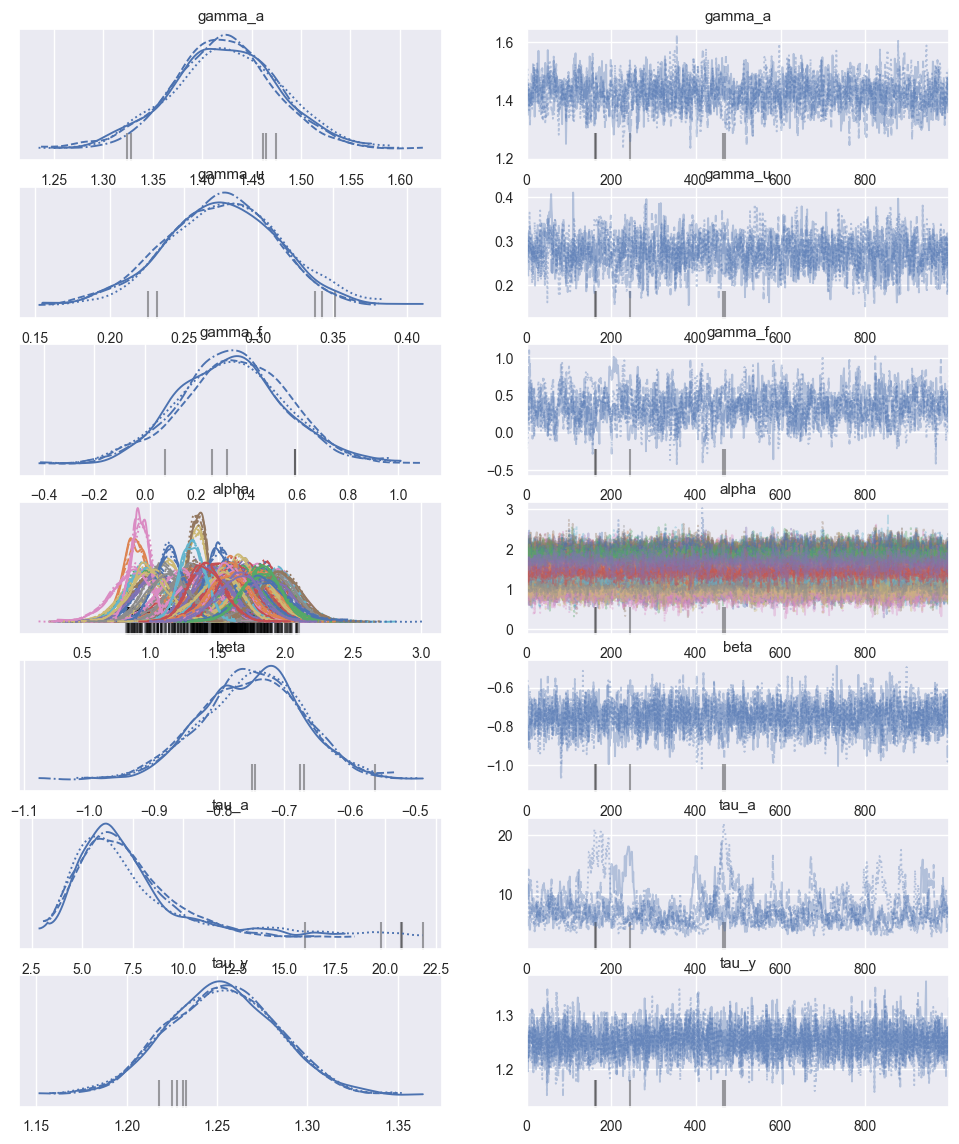

In [27]:
with m5:
    trace_m5 = pm.sample(target_accept=0.95)
    posterior_m5 = pm.sample_posterior_predictive(trace_m5)
    pm.plot_trace(trace_m5)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

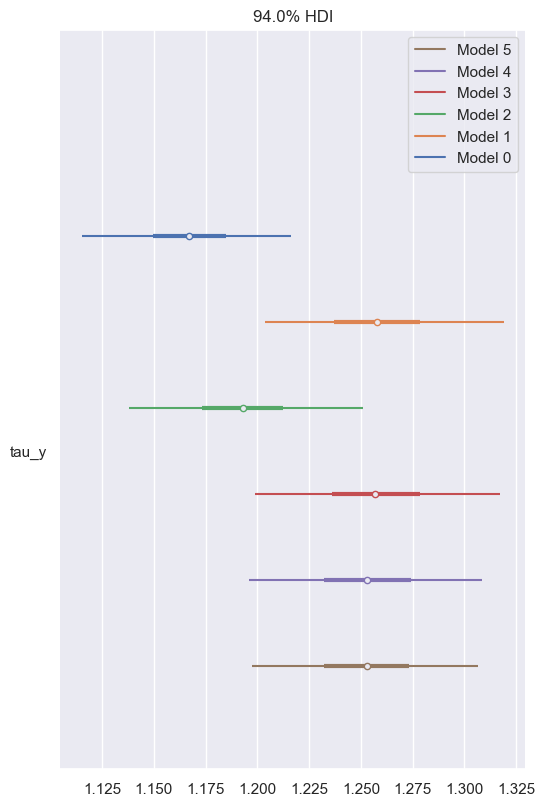

In [28]:
pm.plot_forest([trace_m0, trace_m1, trace_m2, trace_m3, trace_m4, trace_m5], var_names=["tau_y"], combined=True)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

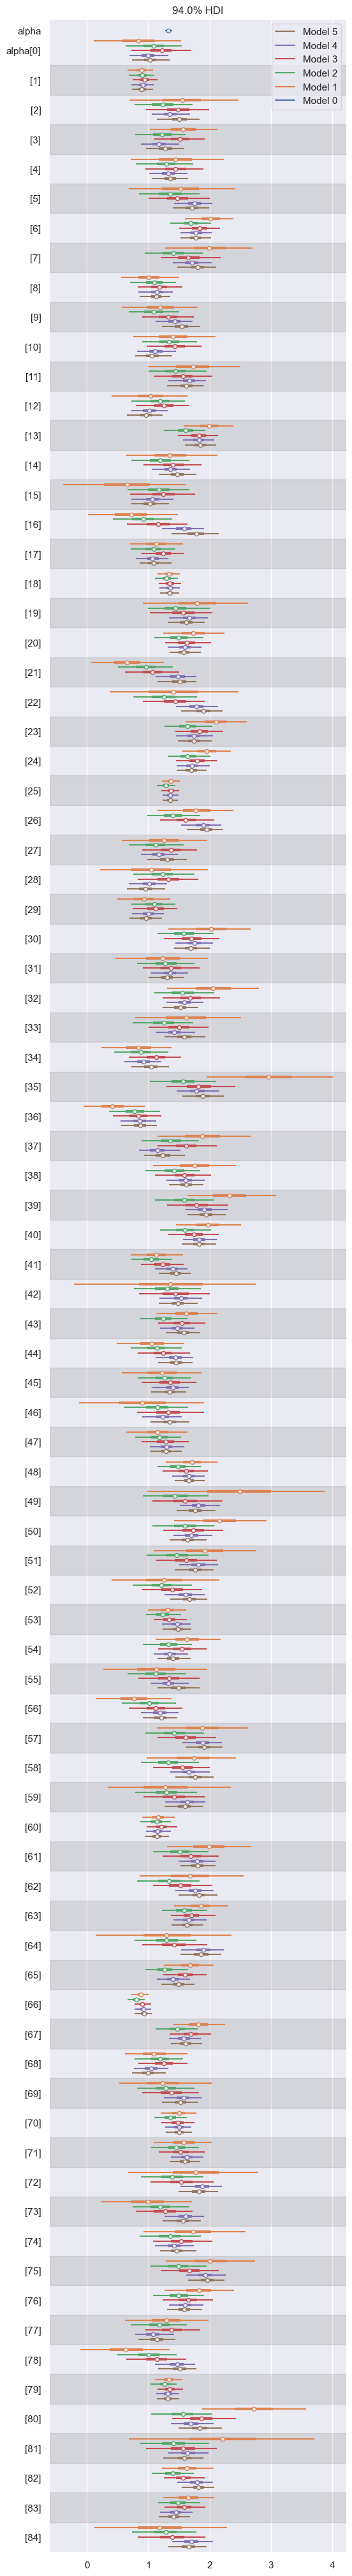

In [29]:
pm.plot_forest([trace_m0, trace_m1, trace_m2, trace_m3, trace_m4, trace_m5], var_names=["alpha"], combined=True)

In [30]:
from sklearn.metrics import mean_squared_error as MSE
print("Complete Pooling:                      {:.5f}".format(MSE(y, posterior_m0.posterior_predictive.mean(dim=["chain","draw"])["obs"])))
print("No Pooling:                            {:.5f}".format(MSE(y, posterior_m1.posterior_predictive.mean(dim=["chain","draw"])["obs"])))
print("Pooled Counties:                       {:.5f}".format(MSE(y, posterior_m2.posterior_predictive.mean(dim=["chain","draw"])["obs"])))
print("Pooled Counties w/ Floor Intercept:    {:.5f}".format(MSE(y, posterior_m3.posterior_predictive.mean(dim=["chain","draw"])["obs"])))
print("Pooled w/ County Uppm:                 {:.5f}".format(MSE(y, posterior_m4.posterior_predictive.mean(dim=["chain","draw"])["obs"])))
print("Pooled w/ Avg Floor:                   {:.5f}".format(MSE(y, posterior_m5.posterior_predictive.mean(dim=["chain","draw"])["obs"])))

Complete Pooling:                      0.73162
No Pooling:                            0.57266
Pooled Counties:                       0.67371
Pooled Counties w/ Floor Intercept:    0.60137
Pooled w/ County Uppm:                 0.65584
Pooled w/ Avg Floor:                   0.65450


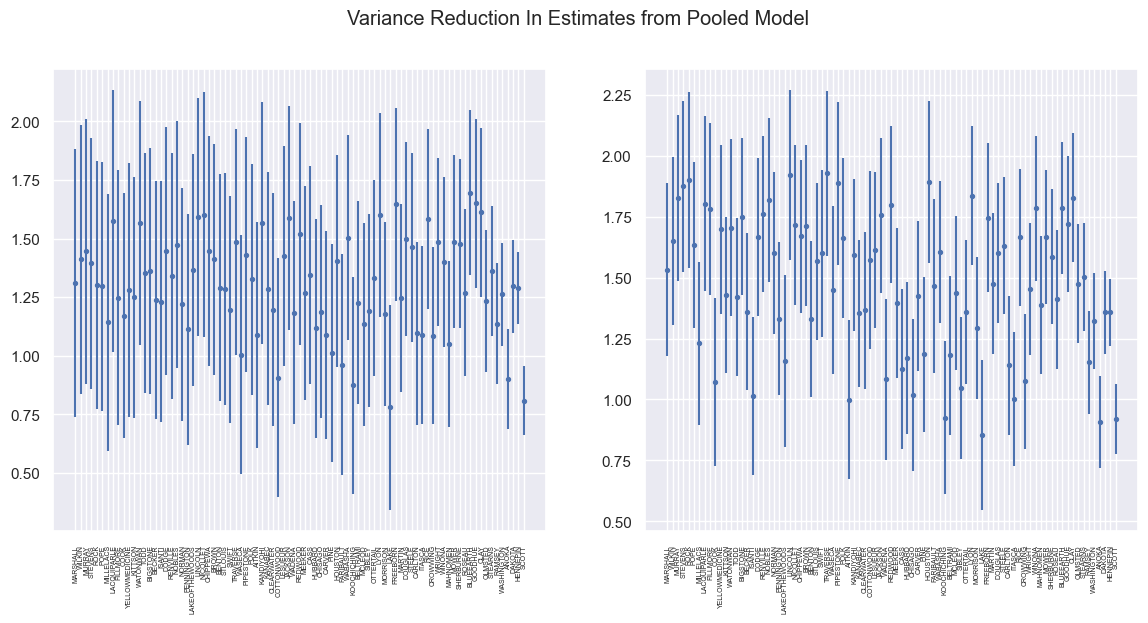

In [31]:
def plot_alphas_comparison(trace1, trace2, sorts=None):
    fig, axs = plt.subplots(1, 2)
    plt.suptitle("Variance Reduction In Estimates from Pooled Model")
    fig.set_size_inches((14,6))

    for i, trace in enumerate([trace1, trace2]):
        post_mean = trace.posterior[["alpha","tau_y"]].mean(dim=["chain","draw"])
        post_sd = trace.posterior[["alpha","tau_y"]].std(dim=["chain","draw"])

        alpha_u = post_mean.get("alpha").to_numpy() + 1.96*post_sd.get("alpha").to_numpy()
        alpha_l = post_mean.get("alpha").to_numpy() - 1.96*post_sd.get("alpha").to_numpy()
        alpha = post_mean.get("alpha").to_numpy()

        if sorts is not None:
            sorted = sorts
        else:
            sorted = np.argsort(alpha)

        axs[i].scatter(x=county_id_map[sorted], y=alpha[sorted], s = 8)
        axs[i].vlines(x=county_id_map[sorted], ymin=alpha_l[sorted], ymax=alpha_u[sorted])
        axs[i].tick_params("x", rotation=90, labelsize=5)


        # return post_mean, post_sd

plot_alphas_comparison(trace_m2, trace_m4, sorts=county_counts_sort)

The end

### Alpha and Beta are modeled independently

In [ ]:
with pm.Model() as model_pooled_vary_intercepts_slope_ind:

    gamma_0 = pm.Normal("gamma_0", mu=0, sigma=10)
    sigma_county = pm.Gamma("sigma_county", mu=3, sigma=2)
    
    alpha = pm.Normal("alpha", mu=gamma_0, sigma=sigma_county, shape=no_counties)
    
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    sigma_floor = pm.Gamma("sigma_floor", mu=3, sigma=2)

    beta = pm.Normal("beta", mu=beta_0, sigma=sigma_floor, shape=no_counties)

    resp = alpha[counties] + beta[counties] * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

In [ ]:
with model_pooled_vary_intercepts_slope_ind:
    trace_pooled_vary_intercepts_slope_ind = pm.sample(target_accept=0.85)
    pm.plot_trace(trace_pooled_vary_intercepts_slope_ind)

### Alpha and Beta are modeled with some covariance between them

In [ ]:
import theano.tensor as tt

with pm.Model() as model_pooled_vary_intercepts_slope:

    theta_ = pm.Normal("theta_", mu=0, sigma=10, shape=2)
    sigma_ = pm.Gamma("sigma_", mu=3, sigma=2, shape=2)
    C_triu = pm.LKJCorr('C_triu', n=2, eta=1)

    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)

    sigma_diag = tt.nlinalg.diag(sigma_)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)
    
    ab = pm.MvNormal("ab", mu=theta_, cov=cov, shape=(no_counties, 2))

    alpha = pm.Deterministic("alpha", ab[:,0])
    beta = pm.Deterministic("Beta", ab[:,1])

    resp = alpha[counties] + beta[counties] * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

In [ ]:
import theano.tensor as tt

with pm.Model() as model_pooled_vary_intercepts_slope:

    alpha_ = pm.Normal("alpha_", mu=0, sigma=10)
    beta_ = pm.Normal("beta_", mu=0, sigma=10)

    sigma_ = pm.Gamma("sigma_", mu=3, sigma=2, shape=2)
    C_triu = pm.LKJCorr('C_triu', n=2, eta=2)
    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)

    sigma_diag = tt.nlinalg.diag(sigma_)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)
    
    ab = pm.MvNormal("ab", mu=tt.stack([alpha_, beta_]), cov=cov, shape=(no_counties, 2))

    alpha = pm.Deterministic("alpha", ab[:,0])
    beta = pm.Deterministic("Beta", ab[:,1])

    resp = alpha[counties] + beta[counties] * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

In [ ]:
with model_pooled_vary_intercepts_slope:
    trace_pooled_vary_intercepts_slope = pm.sample(target_accept=0.9)
    pm.plot_trace(trace_pooled_vary_intercepts_slope)

In [ ]:
means = []
sds = []
for i in np.argsort(county_observations):
    means.append(np.mean(trace_pooled_vary_intercepts_slope["alpha"][:,i]))
    sds.append(np.std(trace_pooled_vary_intercepts_slope["alpha"][:,i]))

mean_pooled_vary_slopes= np.array(means)
sd_pooled_vary_slopes = np.array(sds)

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("County Level Standard Deviation vs. Nobs in County")
ax.scatter(np.sort(county_observations), sd_pooled, s=4, label="pooled")
ax.scatter(np.sort(county_observations), sd_no_pooled, s=4, label="no pooling")
ax.scatter(np.sort(county_observations), sd_pooled_vary_slopes, s=4, label="pooled-vary slopes")
ax.set_xscale("log")
ax.legend()

### Add the group level predictor (county) and uranium to model the pooled predictor and then model floors

In [ ]:
with pm.Model() as model:

    gamma_0 = pm.Normal("gamma_0", mu=0, sd=10)
    gamma_1 = pm.Normal("gamma_1", mu=0, sd=10)
    sigma_a_ = pm.Exponential("sigma_a_", 1)
    a_error = pm.Normal("a_error", mu=0, sigma=sigma_a_, shape=no_counties)
    mu_ = gamma_0 + gamma_1*u
    alpha = pm.Deterministic("alpha", mu_ + a_error[counties])

    beta = pm.Normal("beta", mu=0, sigma=10)

    resp = alpha + beta * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

In [ ]:
import theano.tensor as tt

with pm.Model() as model:

    gamma_0 = pm.Normal("gamma_0", mu=0, sd=10)
    gamma_1 = pm.Normal("gamma_1", mu=0, sd=10)
    # sigma_a_ = pm.Exponential("sigma_a_", 1)
    # a_error = pm.Normal("a_error", mu=0, sigma=sigma_a_, shape=no_counties)
    mu_ = gamma_0 + gamma_1*u
    # alpha_ = pm.Deterministic("alpha", mu_ + a_error[counties])

    tt.matrix()

    theta_ = pm.Normal("theta_", mu=0, sigma=10, shape=2)

    ## Covariance Matrix
    C_triu = pm.LKJCorr('C_triu', n=2, eta=1)
    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)
    sigma_diag = tt.nlinalg.diag(sigma_)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)

    ab = pm.MvNormal("ab", mu=theta_, cov=cov, shape=(no_counties, 2))


    alpha = pm.Deterministic("alpha", ab[:,0])
    beta = pm.Deterministic("beta", ab[:,1])

    resp = alpha[counties] + beta[counties] * x

    sigma_y = pm.Exponential("sigma_y", 1)

    # obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)



    # beta = pm.Normal("beta", mu=0, sigma=10)

    # resp = alpha + beta * x

    # sigma_y = pm.Exponential("sigma_y", 1)

    # obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)